In [12]:
!pip install torch torchvision

In [0]:
import torch
from torchvision import datasets 
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler 

In [14]:
import numpy as np
batch_size = 20
valid_size = 0.2
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

num_train = len(train_data)#The length
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx,valid_idx = indices[split:],indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
num_workers = 0
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
def imshow(img):
    img = img/ 2+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

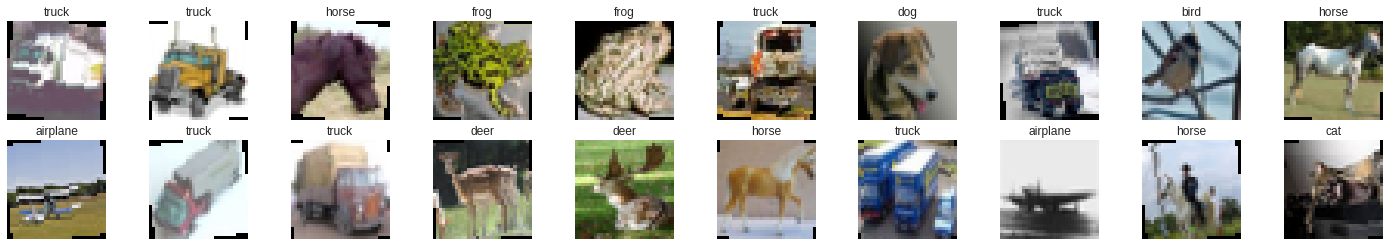

In [16]:
images , labels = next(iter(train_loader))
images = images.numpy()
fig = plt.figure(figsize = (25,4))
for i in np.arange(20):
  ax = fig.add_subplot(2,20/2,i+1,xticks=[],yticks=[])
  imshow(images[i])
  ax.set_title(classes[labels[i]])

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv1 = nn.Conv2d(3,16,3,padding = 1)
    self.conv2 = nn.Conv2d(16,32,3,padding = 1)
    self.conv3 = nn.Conv2d(32,64,3,padding =1)
    self.pool = nn.MaxPool2d(2,2)
    self.h1 = nn.Linear(64*4*4,500)
    self.h2 = nn.Linear(500,10)
    self.dropout = nn.Dropout(0.30)
  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1,64*4*4)
    x = self.dropout(x)
    x = F.relu(self.h1(x))
    x = self.dropout(x)
    x = self.h2(x)
    return x
  
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (h1): Linear(in_features=1024, out_features=500, bias=True)
  (h2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.3)
)


In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr = 0.01)

In [23]:
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
       
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.912515 	Validation Loss: 0.208955
Validation loss decreased (inf --> 0.208955).  Saving model ...
Epoch: 2 	Training Loss: 0.875169 	Validation Loss: 0.207330
Validation loss decreased (0.208955 --> 0.207330).  Saving model ...
Epoch: 3 	Training Loss: 0.846209 	Validation Loss: 0.199337
Validation loss decreased (0.207330 --> 0.199337).  Saving model ...
Epoch: 4 	Training Loss: 0.817936 	Validation Loss: 0.189009
Validation loss decreased (0.199337 --> 0.189009).  Saving model ...
Epoch: 5 	Training Loss: 0.794293 	Validation Loss: 0.191475
Epoch: 6 	Training Loss: 0.775480 	Validation Loss: 0.181966
Validation loss decreased (0.189009 --> 0.181966).  Saving model ...
Epoch: 7 	Training Loss: 0.756261 	Validation Loss: 0.183343
Epoch: 8 	Training Loss: 0.736922 	Validation Loss: 0.175861
Validation loss decreased (0.181966 --> 0.175861).  Saving model ...
Epoch: 9 	Training Loss: 0.720042 	Validation Loss: 0.170575
Validation loss decreased (0.175861 --> 0.

In [28]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) 
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.676427

Test Accuracy of airplane: 79% (794/1000)
Test Accuracy of automobile: 86% (863/1000)
Test Accuracy of  bird: 62% (628/1000)
Test Accuracy of   cat: 62% (621/1000)
Test Accuracy of  deer: 70% (709/1000)
Test Accuracy of   dog: 61% (614/1000)
Test Accuracy of  frog: 83% (837/1000)
Test Accuracy of horse: 83% (833/1000)
Test Accuracy of  ship: 87% (878/1000)
Test Accuracy of truck: 84% (849/1000)

Test Accuracy (Overall): 76% (7626/10000)


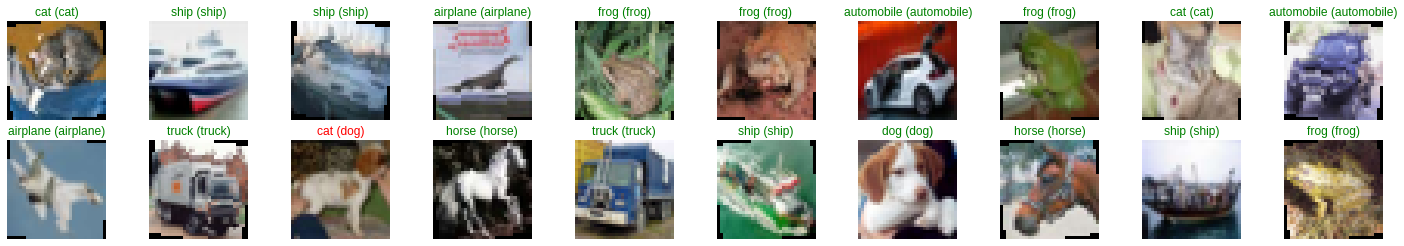

In [29]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) 

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
